Mục tiêu: 
    Phát hiện lỗi tiềm ẩn, nhiễu, giá trị thiếu
    Quan sát các xu hướng
    Quan sát các đặc trưng đóng vai trò quan trọng
    Tìm ra các vi phạm hoặc các giả thiết thống kê có thể có từ các quan sát
    Giảm chiều, tăng cường


Các bước phân tích và trực quan hóa dữ liệu 



In [1]:
import os
import zipfile
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from torchvision import datasets, transforms
from collections import Counter
from PIL import Image
import random
import torch
from torch.utils.data import DataLoader
import cv2
from tqdm import tqdm
import shutil

In [2]:
data_dir = "../EDA data"
train_dir = "../EDA data/train"
test_dir = "../EDA data/test"
dataset = datasets.ImageFolder(root=data_dir)
trainset = datasets.ImageFolder(root=train_dir)
testset = datasets.ImageFolder(root=test_dir)

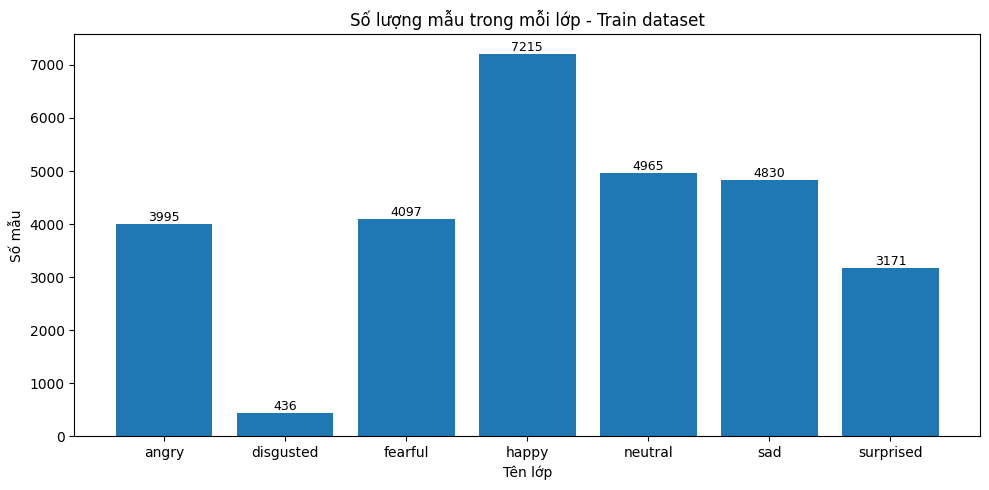

In [3]:
labels = [label for _, label in trainset.imgs]
class_counts = Counter(labels)

class_names = [trainset.classes[idx] for idx in sorted(class_counts.keys())]
counts = [class_counts[idx] for idx in sorted(class_counts.keys())]

plt.figure(figsize=(10,5))
plt.bar(class_names, counts)

for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)

plt.title("Số lượng mẫu trong mỗi lớp - Train dataset")
plt.xlabel("Tên lớp")
plt.ylabel("Số mẫu")
plt.tight_layout()
plt.show()


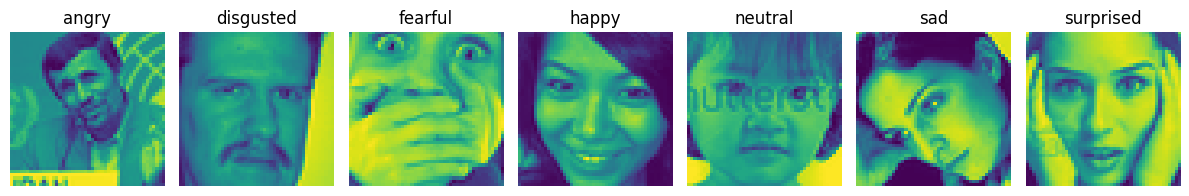

In [4]:
class_to_images = {class_name: [] for class_name in trainset.classes}
for img_path, label in trainset.imgs:
    class_name = trainset.classes[label]
    if class_name in class_to_images:
        class_to_images[class_name].append(img_path)

plt.figure(figsize=(12, 6))
for idx, (class_name, image_list) in enumerate(class_to_images.items()):
    if len(image_list) == 0: 
        continue
    img_path = random.choice(image_list)
    img = Image.open(img_path)

    plt.subplot(1, len(trainset.classes), idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
from PIL import Image
from tqdm import tqdm
import shutil


train_old = "../EDA data/train"


train_augmented = "../EDA data/train_augmented"


if os.path.exists(train_augmented):
    shutil.rmtree(train_augmented)
os.makedirs(train_augmented)


def augment_and_save(old_dir, new_dir):
    for class_name in os.listdir(old_dir):
        class_path = os.path.join(old_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        save_class_path = os.path.join(new_dir, class_name)
        os.makedirs(save_class_path, exist_ok=True)

        for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).convert("RGB")

            base_name, ext = os.path.splitext(img_name)

            
            img.save(os.path.join(save_class_path, f"{base_name}{ext}"))

            #  Lật ngang
            img_flip = img.transpose(Image.FLIP_LEFT_RIGHT)
            img_flip.save(os.path.join(save_class_path, f"{base_name}_flip{ext}"))

            #  Lật dọc
            img_vflip = img.transpose(Image.FLIP_TOP_BOTTOM)
            img_vflip.save(os.path.join(save_class_path, f"{base_name}_vflip{ext}"))

            
            img_rot1 = img.rotate(15, expand=True)
            img_rot1.save(os.path.join(save_class_path, f"{base_name}_rot15{ext}"))

            
            img_rot2 = img.rotate(-15, expand=True)
            img_rot2.save(os.path.join(save_class_path, f"{base_name}_rot_15{ext}"))


augment_and_save(train_old, train_augmented)

print("DONE — Dataset mới đã lưu tại folder: train_augmented")


Processing surprised: 100%|██████████| 3171/3171 [01:03<00:00, 49.57it/s]

🔥 DONE — Dataset mới đã lưu tại folder: train_augmented 🎉


In [12]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

trainset_transform = datasets.ImageFolder(root=train_augmented, transform=transform_train)
testset_transform  = datasets.ImageFolder(root=test_dir, transform=transform_test)

trainloader = DataLoader(trainset_transform, batch_size=32, shuffle=True)
testloader  = DataLoader(testset_transform, batch_size=32, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


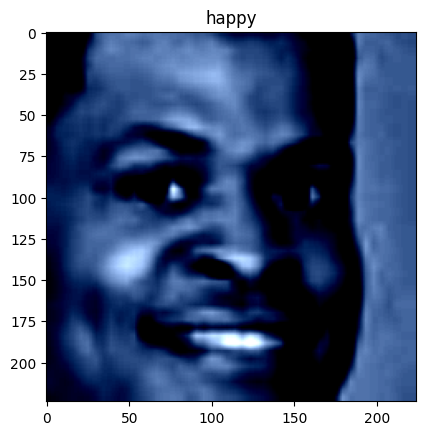

In [13]:
img, label = random.choice(trainset_transform)
plt.imshow(img.permute(1,2,0))
plt.title(trainset_transform.classes[label])
plt.show()


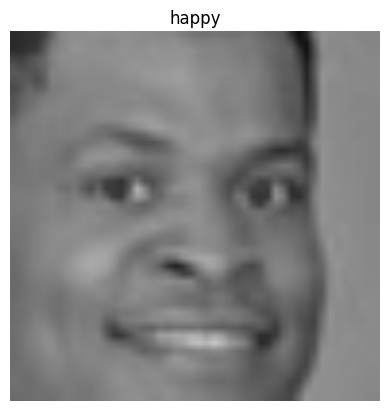

In [14]:

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

img_np = img.numpy().transpose((1,2,0))   
img_np = (img_np * std) + mean            
img_np = np.clip(img_np, 0, 1)            

plt.imshow(img_np)
plt.title(trainset_transform.classes[label])
plt.axis('off')
plt.show()


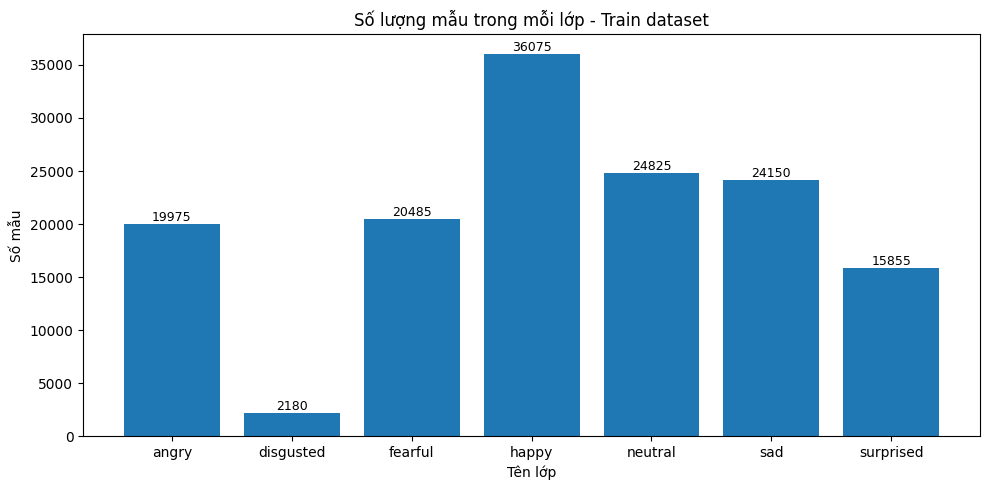

In [15]:
labels = [label for _, label in trainset_transform.imgs]
class_counts = Counter(labels)

class_names = [trainset_transform.classes[idx] for idx in sorted(class_counts.keys())]
counts = [class_counts[idx] for idx in sorted(class_counts.keys())]

plt.figure(figsize=(10,5))
plt.bar(class_names, counts)

for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)

plt.title("Số lượng mẫu trong mỗi lớp - Train dataset")
plt.xlabel("Tên lớp")
plt.ylabel("Số mẫu")
plt.tight_layout()
plt.show()


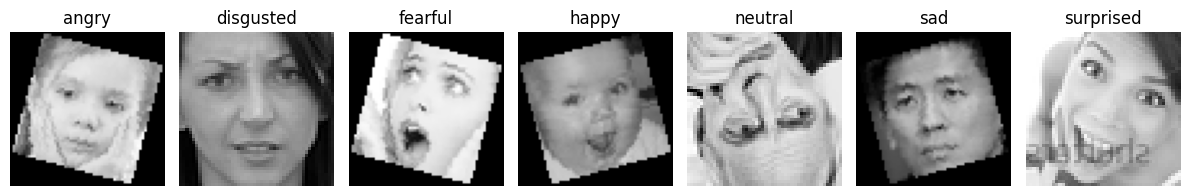

In [16]:
class_to_images = {class_name: [] for class_name in trainset_transform.classes}
for img_path, label in trainset_transform.imgs:
    class_name = trainset_transform.classes[label]
    if class_name in class_to_images:
        class_to_images[class_name].append(img_path)

plt.figure(figsize=(12, 6))
for idx, (class_name, image_list) in enumerate(class_to_images.items()):
    if len(image_list) == 0: 
        continue
    img_path = random.choice(image_list)
    img = Image.open(img_path)

    plt.subplot(1, len(trainset_transform.classes), idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()